# Build Collaborative Filtering Recommendation System

## 1. read data

download data from https://github.com/tangn121/echo-chambers-in-recommendation-systems-NMF/blob/main/ml-100k.zip and unzip it.

In [2]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
#from cmfrec import CMF
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [3]:
# load movie ratings (change it into your local file path)
movie_ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])

In [4]:
movie_ratings

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [5]:
# load user info and drop rows with missing values
user_info = pd.read_csv('ml-100k/u.user', sep='|', names=['user_id', 'age', 'gender', 'occupation', 'zip_code']).dropna()

In [6]:
user_info

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
...,...,...,...,...,...
938,939,26,F,student,33319
939,940,32,M,administrator,02215
940,941,20,M,student,97229
941,942,48,F,librarian,78209


## 2. build recommendation system based on movie ratings (NMF)

In [7]:
# construct the user-item matrix, which is V
def construct_v (row, col, data, shape):
    V = csr_matrix((data, (row, col)), shape = shape).todense()
    V = V[1:, 1:]
    return np.squeeze(np.asarray(V))

In [8]:
movie_row = movie_ratings['user_id'].values
movie_col = movie_ratings['item_id'].values
movie_data = movie_ratings['rating'].values
num_users = len(np.unique(movie_row))
num_movies = len(np.unique(movie_col))
movie_shape = (num_users+1, num_movies+1)

In [9]:
V_rating = construct_v(movie_row, movie_col, movie_data, movie_shape)

In [10]:
V_rating


array([[5, 3, 4, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0]])

In [11]:
V_rating.shape

(943, 1682)

In [12]:
V_train, V_test = train_test_split(V_rating, test_size=0.3, random_state=42)

In [13]:
V_train.shape

(660, 1682)

In [14]:
V_test.shape

(283, 1682)

In [17]:
# hyperparameter tuning
movie_parameters = {'n_components': [2, 5, 10, 15, 20],
                    'max_iter': [100, 200, 500],
                    'alpha': [0.0, 0.1, 0.5, 1],
                    'l1_ratio': [0.0, 0.1, 0.5, 1]}

In [ ]:
estimator_movie = NMF(random_state=42)

grid_search_movie = GridSearchCV(estimator_movie, movie_parameters, scoring='neg_mean_squared_error')

print('Performing grid search...')

grid_search_movie.fit(V_train)

In [80]:
grid_search_movie.best_estimator_

NMF(max_iter=100, n_components=2, random_state=42)

In [15]:
# fit model on the full dataset with the best parameter
best_estimator_movie = NMF(max_iter=100, n_components=2, random_state=42)

W_movie = best_estimator_movie.fit_transform(V_rating)
H_movie = best_estimator_movie.components_

V_rating_pred = W_movie @ H_movie

# since the rating is between 1 and 5, we need to change the value, and we also round the number
V_rating_pred[V_rating_pred > 5] = 5
V_rating_pred[V_rating_pred < 1] = 1
V_rating_pred = np.rint(V_rating_pred)
V_rating_pred.shape

(943, 1682)

In [24]:
np.savetxt("nmf_original.csv", V_rating_pred, delimiter=",")

``rerun here``

In [16]:
def simulation(V_rating_init=V_rating,V_rating_pred_init=V_rating_pred,sample_size=0.1,n_epoch=10):
    user_idx = []
    num_rows = V_rating_pred_init.shape[0]
    indices = list(np.arange(num_rows))
    for i in range(n_epoch):
        V_other, sampled_V_rating = train_test_split(V_rating_pred_init, test_size=sample_size, random_state=42)
        V_rating_init = np.append(V_rating_init,sampled_V_rating,0)
        
        train_idx, sampled_V_rating_idx = train_test_split(indices, test_size=sample_size, random_state=42)
        lst_sampled_V_rating_idx = list(sampled_V_rating_idx)
        indices = indices + lst_sampled_V_rating_idx

        W_movie = best_estimator_movie.fit_transform(V_rating_init)
        H_movie = best_estimator_movie.components_

        V_rating_pred_init = W_movie @ H_movie

        # since the rating is between 1 and 5, we need to change the value, and we also round the number
        V_rating_pred_init[V_rating_pred_init > 5] = 5
        V_rating_pred_init[V_rating_pred_init < 1] = 1
        V_rating_pred_init = np.rint(V_rating_pred_init)
    return V_rating_pred_init,indices

In [114]:
simulated, user_idx = simulation()
#np.savetxt("nmf_simulate.csv", simulated, delimiter=",")

## 3. build recommendation system based on movie ratings + user info (CMF)

Collective matrix Factorization（CMF）is a method of factoring two or more relational data (matrix) at the same time when a set has multiple relations.

In [24]:
user_ids = user_info['user_id'].values
# split user into train and test
user_train, user_test = train_test_split(user_ids, test_size=0.3, random_state=42)

rating_train = movie_ratings.loc[movie_ratings.user_id.isin(user_train)]
rating_test = movie_ratings.loc[movie_ratings.user_id.isin(user_test)]

rating_row_train = rating_train['user_id'].values
rating_col_train = rating_train['item_id'].values
rating_data_train = rating_train['rating'].values
num_users_train = len(np.unique(rating_row_train))
num_movies_train = len(np.unique(rating_col_train))
rating_train_shape = (num_users+1, num_movies+1) # some users may not rate other movies, we then mark this as 0

rating_row_test = rating_test['user_id'].values
rating_col_test = rating_test['item_id'].values
rating_data_test = rating_test['rating'].values
num_users_test = len(user_test)
num_movies_test = len(np.unique(rating_col_test))
rating_test_shape = (num_users+1, num_movies+1)

In [25]:
# construct x
X_train = construct_v (rating_row_train, rating_col_train, rating_data_train, rating_train_shape)
X_train = X_train[~np.all(X_train == 0, axis=1)] # get rid of user rows that don't belong to training set

X_test = construct_v (rating_row_test, rating_col_test, rating_data_test, rating_test_shape)
X_test = X_test[~np.all(X_test == 0, axis=1)]

In [26]:
X_train.shape

(660, 1682)

In [27]:
X_test.shape

(283, 1682)

In [28]:
# one hot encoder for user attribute
# get rid of zipcode
user_info = user_info[['user_id', 'age', 'gender', 'occupation']]
user_info = pd.get_dummies(data=user_info, columns=['age', 'gender', 'occupation'])

In [29]:
user_info

,user_id,age_7,age_10,age_11,age_13,age_14,age_15,age_16,age_17,age_18,...,occupation_marketing,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,939,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
939,940,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
940,941,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
941,942,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
user_attr_train = user_info.loc[user_info.user_id.isin(user_train)]
user_attr_test = user_info.loc[user_info.user_id.isin(user_test)]

In [31]:
y_train = user_attr_train.iloc[:,1:].to_numpy() # remove user_id column
y_test = user_attr_test.iloc[:,1:].to_numpy()

In [32]:
# hyperparameter tuning
param = {
         'k': [30, 50, 100],
         'lambda_': [0.01, 0.1, 5, 20, 50],
         'w_main': [0.1, 0.25, 0.5]}

In [33]:
param_set = []
errors = []
for k in param['k']:
    for lam in param['lambda_']:
        for w in param['w_main']:
            model_with_sideinfo = CMF(k=k, lambda_=lam, w_main=w)
            model_with_sideinfo.fit(X=X_train, U=y_train)
            rating_pred = model_with_sideinfo.predict(user=rating_row_test, item=rating_col_test)
            rating_pred[rating_pred > 5] = 5
            rating_pred[rating_pred < 1] = 1
            rating_pred = np.rint(rating_pred)
            error = mean_squared_error(rating_data_test, rating_pred)
            errors.append(error)
            param_set.append((k, lam, w))

Starting ALS optimization routine

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  1

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  2

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  3

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  4

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  5

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  6

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  7

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  8

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  9

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration 10

ALS procedure terminated successfully
Starting ALS optimization routine

Up

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  6

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  7

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  8

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  9

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration 10

ALS procedure terminated successfully
Starting ALS optimization routine

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  1

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  2

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  3

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  4

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  5

Updating C ... done
Updating B ... do

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  1

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  2

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  3

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  4

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  5

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  6

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  7

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  8

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  9

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration 10

ALS procedure terminated successfully
Starting ALS optimization routine

Updating C ... done
Updating B ... do

Updating A ... done
	Completed ALS iteration  6

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  7

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  8

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  9

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration 10

ALS procedure terminated successfully
Starting ALS optimization routine

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  1

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  2

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  3

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  4

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  5

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS it

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  1

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  2

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  3

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  4

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  5

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  6

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  7

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  8

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  9

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration 10

ALS procedure terminated successfully
Starting ALS optimization routine

Updating C ... done
Updating B ... do

Updating A ... done
	Completed ALS iteration  6

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  7

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  8

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  9

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration 10

ALS procedure terminated successfully
Starting ALS optimization routine

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  1

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  2

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  3

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  4

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  5

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS it

In [34]:
min_error_index = errors.index(min(errors))
best_param = param_set[min_error_index]

In [35]:
best_param

(100, 0.01, 0.5)

In [36]:
# fit model on the full dataset with the best parameter
u = user_info.iloc[:,1:].to_numpy()

best_estimator_plus_user = CMF(method='als', k=100, lambda_=0.01, w_main=0.5)
best_estimator_plus_user.fit(X=V_rating, U=u)

Starting ALS optimization routine

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  1

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  2

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  3

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  4

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  5

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  6

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  7

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  8

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  9

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration 10

ALS procedure terminated successfully


Collective matrix factorization model
(explicit-feedback variant)


In [37]:
def get_predicted_rating(V_rating_init=V_rating):
    
    # fit model on the full dataset with the best parameter
    u = user_info.iloc[:,1:].to_numpy()

    best_estimator_plus_user = CMF(method='als', k=100, lambda_=0.01, w_main=0.5)
    best_estimator_plus_user.fit(X=V_rating_init, U=u)

    item_id_lst = np.unique(movie_col)
    v_rating_pred= best_estimator_plus_user.predict(user=[1]*item_id_lst.shape[0],item=item_id_lst).reshape((1,1682))

    for i in range(2,V_rating_init.shape[0]+1):
        v_rating_pred_single = best_estimator_plus_user.predict(user=[i]*item_id_lst.shape[0],item=item_id_lst).reshape((1,1682))
        v_rating_pred = np.append(v_rating_pred,v_rating_pred_single,0)
    return v_rating_pred

In [38]:
V_rating_pred.shape

(943, 1682)

In [40]:
V_rating_pred = get_predicted_rating(V_rating_init=V_rating)
np.savetxt("cmf_original.csv", V_rating_pred, delimiter=",")

Starting ALS optimization routine

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  1

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  2

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  3

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  4

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  5

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  6

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  7

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  8

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  9

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration 10

ALS procedure terminated successfully


``rerun here``

In [41]:
def simulation_cmf(V_rating_init=V_rating,V_rating_pred_init=V_rating_pred,sample_size=0.1,n_epoch=10):
    user_idx = []
    num_rows = V_rating_pred_init.shape[0]
    indices = list(np.arange(num_rows))
    
    for i in range(n_epoch):
        V_other, sampled_V_rating = train_test_split(V_rating_pred_init, test_size=sample_size, random_state=42)
        V_rating_init = np.append(V_rating_init,sampled_V_rating,0)

        train_idx, sampled_V_rating_idx = train_test_split(indices, test_size=sample_size, random_state=42)
        lst_sampled_V_rating_idx = list(sampled_V_rating_idx)
        indices = indices + lst_sampled_V_rating_idx

        V_rating_pred_init = get_predicted_rating(V_rating_init=V_rating_init)

        # since the rating is between 1 and 5, we need to change the value, and we also round the number
        V_rating_pred_init[V_rating_pred_init > 5] = 5
        V_rating_pred_init[V_rating_pred_init < 1] = 1
        V_rating_pred_init = np.rint(V_rating_pred_init)
    return V_rating_pred_init, indices

In [42]:
simulated = simulation_cmf()
np.savetxt("cmf_simulate.csv", simulated, delimiter=",")

Starting ALS optimization routine

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  1

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  2

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  3

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  4

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  5

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  6

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  7

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  8

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  9

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration 10

ALS procedure terminated successfully
Starting ALS optimization routine

Up

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  6

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  7

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  8

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  9

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration 10

ALS procedure terminated successfully
Starting ALS optimization routine

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  1

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  2

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  3

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  4

Updating C ... done
Updating B ... done
Updating A ... done
	Completed ALS iteration  5

Updating C ... done
Updating B ... do

In [44]:
simulated.shape

(2455, 1682)

### output diversity evaluation 

In [18]:
item_info = pd.read_csv('item.csv', sep='|', names = ['movie_id',"movie_title","release_date","video_release_date","IMBD_url","unknow","Action",
                    "Adventure","Animation","Children's","Comedy","Crime","Documentary","Drama","Fantasy","Film-Noir",
                    'Horror',"Musical","Mystery","Romance","Sci-Fi","Thriller","War","Western"])
item_info['movie_id'] = item_info['movie_id'].str.extract('(.+?),')
item_info['Western'] = item_info['Western'].replace(r'\\n',' ', regex=True)
item_info['Western'] = item_info['Western'].replace(r"'",' ', regex=True)
item_info['Western'] = item_info['Western'].replace(r'"',' ', regex=True)
item_info = item_info.iloc[1: , :]


## movie to type 
item_info['genre_vector'] = item_info.iloc[:,5:].values.tolist()
item_info['genre_vector'] = item_info['genre_vector'].apply(pd.to_numeric)
item_info['movie_id'] = item_info['movie_id'].apply(pd.to_numeric)
movie_id_to_gener = {i.movie_id:i.genre_vector for i in item_info.itertuples()}
movie_id_to_gener

## historical rating 
historical_ratings = pd.DataFrame(V_rating)
historical_ratings.index.name = "user_id"
historical_ratings = historical_ratings.reset_index()
historical_ratings = pd.melt(historical_ratings, id_vars = "user_id")
historical_ratings['value'] = historical_ratings['value'].apply(pd.to_numeric)
historical_ratings_top10 = historical_ratings.sort_values(["user_id","value"], ascending = [True, False]).groupby("user_id").head(10)
historical_ratings_top10 = historical_ratings_top10.rename({'user_id': 'user_id', 'variable': 'variable_ori','value': 'value_ori'}, axis=1)
historical_ratings_top10

,user_id,variable_ori,value_ori
0,0,0,5
4715,0,5,5
7544,0,8,5
10373,0,11,5
11316,0,12,5
...,...,...,...
60351,942,63,5
65066,942,68,5
74496,942,78,5
86755,942,91,5


### nmf

In [23]:
from scipy.spatial.distance import jaccard
from sklearn.metrics import jaccard_score

mean_sim_nmf = []
user_sim = []
for epoch in range(1,31):
    sim = []
    print(epoch)
    simulated, user_idx = simulation(n_epoch=epoch)
    df = pd.DataFrame(simulated)
    df.index = user_idx
    df.index.name = "user_id"
    df = df.reset_index()
    df = pd.melt(df, id_vars = "user_id")
    df['value'] = df['value'].apply(pd.to_numeric)
    df_top10 = df.sort_values(["user_id","value"], ascending = [True, False]).groupby("user_id").head(10)
    df_top10 = df_top10.rename({'user_id': 'user_id', 'variable': 'variable_pred','value': 'value_pred'}, axis=1)
    final_set = pd.merge(historical_ratings_top10,df_top10, on = "user_id")
    final_set = final_set.assign(gener_ori = lambda x: x.variable_ori.map(movie_id_to_gener))
    final_set = final_set.assign(gener_pred = lambda x: x.variable_pred.map(movie_id_to_gener))
    for index, row in final_set.iterrows():
        sim.append(jaccard(row['gener_ori'], row['gener_pred']))
    final_set['sim'] = sim
    user_sim.append(final_set.groupby("user_id").mean(sim)['sim'].values)
    mean_sim_nmf.append(np.mean(sim))


1
2
3
4
5
6
7
8


In [191]:
simulated, user_idx = simulation(n_epoch=30)
df = pd.DataFrame(simulated)
df.index = user_idx
df.index.name = "user_id"
df = df.reset_index()
df = pd.melt(df, id_vars = "user_id")
df['value'] = df['value'].apply(pd.to_numeric)
user_epoch30 = df.loc[df['user_id'] == 0]
user_epoch30 = user_epoch30.assign(gener_pred = lambda x: x.variable.map(movie_id_to_gener))

In [210]:
user_epoch30.to_csv("user_opoch30.csv")

In [211]:
user_epoch1.to_csv("user_epoch1.csv")

In [207]:
simulated, user_idx = simulation(n_epoch=1)
df = pd.DataFrame(simulated)
df.index = user_idx
df.index.name = "user_id"
df = df.reset_index()
df = pd.melt(df, id_vars = "user_id")
df['value'] = df['value'].apply(pd.to_numeric)
user_epoch1 = df.loc[df['user_id'] == 0]
user_epoch1 = user_epoch1.assign(gener_pred = lambda x: x.variable.map(movie_id_to_gener))

In [208]:
user_epoch1

,user_id,variable,value,gener_pred
0,0,0,4.0,"[0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ..."
1038,0,1,1.0,"[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2076,0,2,1.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3114,0,3,3.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, ..."
4152,0,4,1.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, ..."
...,...,...,...,...
1740726,0,1677,1.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
1741764,0,1678,1.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1742802,0,1679,1.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
1743840,0,1680,1.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."


In [82]:
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [200]:
feature = np.array(user['gener_pred'].values.tolist())
label = np.array(user['value'].values.tolist())

In [159]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature)

In [160]:
kmeans = KMeans(
init="random",
n_clusters=3,
n_init=10,
max_iter=300,
random_state=42)

In [87]:
kmeans.fit(scaled_features)

KMeans(init='random', n_clusters=3, random_state=42)

In [161]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

In [92]:
import tarfile
import urllib

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [201]:
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(label)
n_clusters = len(label_encoder.classes_)

In [202]:
preprocessor = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("pca", PCA(n_components=2, random_state = 30)),
    ]
)
clusterer = Pipeline(
   [
       (
           "kmeans",
           KMeans(
               init="k-means++",
               n_init=50,
               max_iter=500,
               random_state=42,
           ),
       ),
   ]
)
pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
)
pipe.fit(feature)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                 ('pca',
                                  PCA(n_components=2, random_state=30))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(max_iter=500, n_init=50,
                                         random_state=42))]))])

In [203]:
preprocessed_data = pipe["preprocessor"].transform(feature)

predicted_labels = pipe["clusterer"]["kmeans"].labels_

silhouette_score(preprocessed_data, predicted_labels)

0.7760402274847654

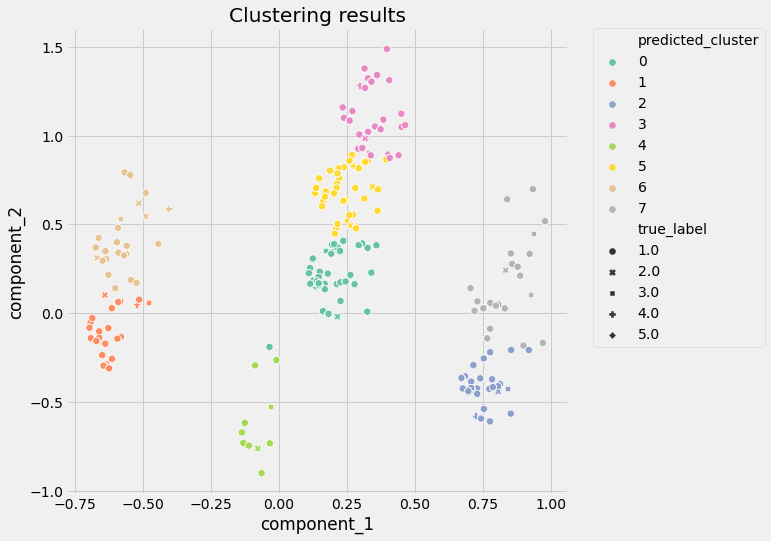

In [204]:
pcadf = pd.DataFrame(
    pipe["preprocessor"].transform(feature),
    columns=["component_1", "component_2"],
)

pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_
pcadf["true_label"] = label_encoder.inverse_transform(true_labels)

plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))

scat = sns.scatterplot(
    "component_1",
    "component_2",
    s=50,
    data=pcadf,
    hue="predicted_cluster",
    style="true_label",
    palette="Set2",
)

scat.set_title(
    "Clustering results"
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.show()

### cmf

In [ ]:
from scipy.spatial.distance import jaccard
from sklearn.metrics import jaccard_score

mean_sim_cmf = []
user_sim = []
for epoch in range(1,31):
    sim = []
    print(epoch)
    simulated, user_idx = simulation_cmf(n_epoch=epoch)
    df = pd.DataFrame(simulated)
    df.index = user_idx
    df.index.name = "user_id"
    df = df.reset_index()
    df = pd.melt(df, id_vars = "user_id")
    df['value'] = df['value'].apply(pd.to_numeric)
    df_top10 = df.sort_values(["user_id","value"], ascending = [True, False]).groupby("user_id").head(10)
    df_top10 = df_top10.rename({'user_id': 'user_id', 'variable': 'variable_pred','value': 'value_pred'}, axis=1)
    final_set = pd.merge(historical_ratings_top10,df_top10, on = "user_id")
    final_set = final_set.assign(gener_ori = lambda x: x.variable_ori.map(movie_id_to_gener))
    final_set = final_set.assign(gener_pred = lambda x: x.variable_pred.map(movie_id_to_gener))
    for index, row in final_set.iterrows():
        sim.append(jaccard(row['gener_ori'], row['gener_pred']))
    final_set['sim'] = sim
    user_sim.append(final_set.groupby("user_id").mean(sim)['sim'].values)
    mean_sim_nmf.append(np.mean(sim))
    mean_sim_cmf.append(np.mean(sim))

In [ ]:
pd.DataFrame(user_sim).to_csv("user_sim_cmf")
pd.DataFrame(mean_sim_cmf).to_csv("mean_sim_cmf")